# Tracking an unknown number of objects

While SVI can be used to learn components and assignments of a mixture model, pyro.contrib.tracking provides more efficient inference algorithms to estimate assignments. This notebook demonstrates how to use the `MarginalAssignmentPersistent` with EM.

In [1]:
%matplotlib inline
from __future__ import absolute_import, division, print_function
import math
import os
import torch
from torch.distributions import constraints
from matplotlib import pyplot
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.tracking.assignment import MarginalAssignmentPersistent
from pyro.contrib.tracking.hashing import LSH, merge_points
from pyro.ops.newton import newton_step
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import ClippedAdam, ASGD, SGD
from pyro.util import warn_if_nan

from datagen_utils import generate_observations, get_positions
from plot_utils import plot_solution, plot_exists_prob
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)

Let's consider a model with deterministic dynamics, say sinusoids with known period but unknown phase and amplitude.

It's tricky to define a fully generative model, so instead we'll separate our data generation process `generate_data()` from a factor graph `model()` that will be used in inference.

In [2]:
@poutine.broadcast
def model(args, observations):
    emission_noise_scale = pyro.param("emission_noise_scale", torch.tensor(0.1234),
                                      constraint=constraints.positive)
    max_num_objects = pyro.sample("max_num_objects",
        dist.Geometric(1./args.max_num_objects)).long().item()
    with pyro.iarange("objects", max_num_objects):
        exists = pyro.sample("exists",
                             dist.Bernoulli(args.expected_num_objects / max_num_objects))
        with poutine.scale(scale=exists):
            states_loc = pyro.sample("states", dist.Normal(0., 1.).expand([2]).independent(1))
            positions = get_positions(states_loc, args.num_frames)
    with pyro.iarange("detections", observations.shape[1]):
        with pyro.iarange("time", args.num_frames):
            # The combinatorial part of the log prob is approximated to allow independence.
            is_observed = (observations[..., -1] > 0)
            with poutine.scale(scale=is_observed.float()):
                assign = pyro.sample("assign",
                                     dist.Categorical(torch.ones(max_num_objects + 1)))
            is_spurious = (assign == max_num_objects)
            is_real = is_observed & ~is_spurious
            num_observed = is_observed.float().sum(-1, True)
            # TODO Make these Bernoulli probs more plausible.
            pyro.sample("is_real",
                        dist.Bernoulli(args.expected_num_objects / max_num_objects),
                        obs=is_real.float())
            pyro.sample("is_spurious",
                        dist.Bernoulli(args.expected_num_spurious / max_num_objects),
                        obs=is_spurious.float())

            # The remaining continuous part is exact.
            observed_positions = observations[..., 0]
            with poutine.scale(scale=is_real.float()):
                bogus_position = positions.new_zeros(args.num_frames, 1)
                augmented_positions = torch.cat([positions, bogus_position], -1)
                predicted_positions = augmented_positions[:, assign]
                pyro.sample("real_observations",
                            dist.Normal(predicted_positions, emission_noise_scale),
                            obs=observed_positions)
            with poutine.scale(scale=is_spurious.float()):
                pyro.sample("spurious_observations", dist.Normal(0., 1.),
                            obs=observed_positions)

In [3]:
def compute_exists_logits(states_loc, replicates):
    FUDGE = -2
    return states_loc.new_empty(states_loc.shape[0]).fill_(-math.log(replicates) + FUDGE)

def compute_assign_logits(positions, observations, replicates, args):
    log_likelihood = detection_log_likelihood(positions, observations, args)
    assign_logits = log_likelihood[...,:-1] - log_likelihood[...,-1:] - math.log(replicates)
    is_observed = (observations[..., -1] > 0)
    assign_logits[~is_observed] = -float('inf')
    return assign_logits

def detection_log_likelihood(positions, observations, args):
    real_dist = dist.Normal(positions.unsqueeze(-2), args.emission_noise_scale)
    spurious_dist = dist.Normal(0., 1.)
    is_observed = (observations[..., -1] > 0)
    observed_positions = observations[..., 0].unsqueeze(-1)
    a=(real_dist.log_prob(observed_positions) +
       math.log(args.expected_num_objects * args.emission_prob))
    b= (spurious_dist.log_prob(observed_positions) +
        math.log(args.expected_num_spurious))
    log_likelihood = torch.cat((a,b), dim=-1)
    log_likelihood[~is_observed] = -float('inf')
    return log_likelihood

## Guide
This guide uses EM.

In [4]:
@poutine.broadcast
def guide(args, observations):
    # Initialize states randomly from the prior.
    states_loc = torch.randn(args.max_num_objects, 2)
    is_observed = (observations[..., -1] > 0)
    
    for em_iter in range(args.em_iters):
        states_loc = states_loc.detach()
        states_loc.requires_grad = True
        positions = get_positions(states_loc,args.num_frames)
        replicates = max(1, states_loc.shape[0]/args.expected_num_objects)
        # E-step: compute soft assignments
        with torch.no_grad():
            assign_logits = compute_assign_logits(positions, observations, replicates, args)
            exists_logits = compute_exists_logits(states_loc, replicates)
            assignment = MarginalAssignmentPersistent(exists_logits, assign_logits,
                                              args.bp_iters, bp_momentum=args.bp_momentum)
            p_exists = assignment.exists_dist.probs
            p_assign = assignment.assign_dist.probs
        
        log_likelihood = detection_log_likelihood(positions,observations, args)
        loss = -(log_likelihood * p_assign).sum()
        # M-step:
        states_loc, _ = newton_step(loss, states_loc, args.emission_noise_scale)
        
        if args.prune_threshold > 0.0:
            states_loc = states_loc[p_exists > args.prune_threshold]
        if args.merge_radius >= 0.0:
            states_loc, _ = merge_points(states_loc, args.merge_radius)
        warn_if_nan(states_loc, 'states_loc')
    
    positions = get_positions(states_loc, args.num_frames)
    replicates = max(1, states_loc.shape[0]/args.expected_num_objects)
    assign_logits = compute_assign_logits(positions, observations, replicates, args)
    exists_logits = compute_exists_logits(states_loc, replicates)
    assignment = MarginalAssignmentPersistent(exists_logits, assign_logits,
                                      args.bp_iters, bp_momentum=args.bp_momentum)
    pyro.sample("max_num_objects", dist.Delta(torch.tensor(float(len(states_loc)))))
    with pyro.iarange("objects", states_loc.shape[0]):
        exists = pyro.sample("exists", assignment.exists_dist, infer={"enumerate": "parallel"})
        with poutine.scale(scale=exists):
            pyro.sample("states", dist.Normal(states_loc, args.emission_noise_scale).independent(1))
    with pyro.iarange("detections", observations.shape[1]):
        with poutine.scale(scale=is_observed.float()):
            with pyro.iarange("time", args.num_frames):
                pyro.sample("assign", assignment.assign_dist, infer={"enumerate": "parallel"})

    return assignment, states_loc

## Generate data

We'll define a global config object to make it easy to port code to `argparse`.

In [5]:
args = type('Args', (object,), {})  # A fake ArgumentParser.parse_args() result.
args.num_frames = 40
args.max_num_objects = 400
args.expected_num_objects = 2.
args.expected_num_spurious = 0.2  # If this is too small, BP will be unstable.
args.emission_prob = 0.8          # If this is too large, BP will be unstable.
args.emission_noise_scale = 0.1   # If this is too small, SVI will see flat gradients.
args.bp_iters = 50
args.svi_iters = 20
args.bp_momentum =0.5
args.em_iters = 10
args.merge_radius = 0.5
args.prune_threshold = 1e-2
assert args.max_num_objects >= args.expected_num_objects

In [6]:
pyro.set_rng_seed(0)
true_states, true_positions, observations = generate_observations(args)
true_num_objects = len(true_states)
max_num_detections = observations.shape[1]
assert true_states.shape == (true_num_objects, 2)
assert true_positions.shape == (args.num_frames, true_num_objects)
assert observations.shape == (args.num_frames, max_num_detections, 1+1)
print("generated {:d} detections from {:d} objects".format(
    (observations[..., -1] > 0).long().sum(), true_num_objects))

generated 78 detections from 2 objects


## Evaluate

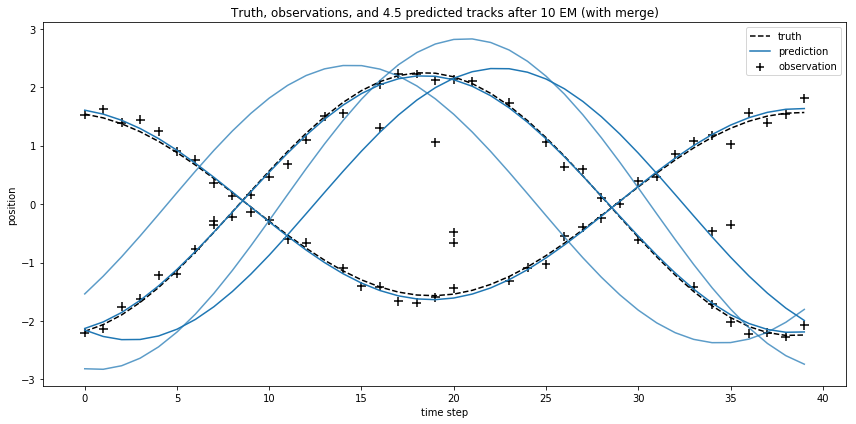

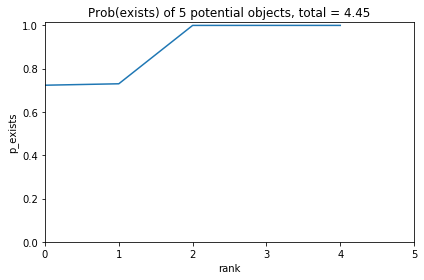

In [7]:
pyro.set_rng_seed(1)  # Use a different seed from data generation
pyro.clear_param_store()
assignment, states_loc = guide(args, observations)
p_exists = assignment.exists_dist.probs
positions = get_positions(states_loc, args.num_frames)
plot_solution(observations, p_exists, positions, true_positions, args, 'after 10 EM (with merge)')
plot_exists_prob(p_exists)

## Training with SVI + EM

In [ ]:
pyro.set_rng_seed(1)  # Use a different seed from data generation
pyro.clear_param_store()

elbo = TraceEnum_ELBO(max_iarange_nesting=2)
optim = ClippedAdam({'lr': 0.1})
svi = SVI(model, guide, optim, elbo)
losses = []
for epoch in range(args.svi_iters):
    loss = svi.step(args, observations)
    losses.append(loss)
    print('epoch {: >3d} loss = {}, emission_noise_scale = {}'.format(
        epoch, loss, pyro.param("emission_noise_scale").item()))
pyplot.figure().patch.set_color('white')
pyplot.plot(losses)

> <ipython-input-2-c94d10269620>(38)model()
     36                 predicted_positions = augmented_positions[:, assign]
     37                 set_trace()
---> 38                 pyro.sample("real_observations",
     39                             dist.Normal(predicted_positions, emission_noise_scale),
     40                             obs=observed_positions)

ipdb> p is_real.shape
torch.Size([6, 1, 40, 4])
ipdb> p predicted_positions.shape
torch.Size([40, 6, 1, 40, 4])


In [ ]:
assignment, states_loc = guide(args, observations)
p_exists = assignment.exists_dist.probs
positions = get_positions(states_loc, args.num_frames)
plot_solution(observations, p_exists, positions, true_positions, args, 'after 10 EM (with prune and merge)')
plot_exists_prob(p_exists)